In [1]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Lambda, Layer, Input
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow import one_hot, abs
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2 as cv
import tkinter as tk
from shapely.geometry import box


In [2]:
(X_train , Y_train) , (X_test , Y_test) = mnist.load_data()

In [3]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = np.expand_dims(X_train , axis=3)
X_test = np.expand_dims(X_test , axis=3)

Y_train = one_hot(Y_train , 10).numpy()
Y_test = one_hot(Y_test , 10).numpy()

In [4]:
def generate_dataset(X , Y , size=(20000, 250, 250 , 1) , min_max=(28 , 70)):
  new_X = []
  new_Y = [[] , []]
  dataset_len = size[0]
  for _ in range(dataset_len):
    bg = np.zeros((size[1] , size[2] , size[3]) , dtype='float32')
    idx = np.random.randint(0 , X.shape[0])
    new_Y[0].append(Y[idx])

    img = X[idx]
    height = width = np.random.randint(min_max[0] , min_max[1])
    img = tf.image.resize(img , (height , width) , method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, preserve_aspect_ratio=True).numpy()
  
    x1 =  np.random.randint(0 , size[2] - width)
    y1 =  np.random.randint(0 , size[1] - height)
    x2 = x1 + width
    y2 = y1 + height
    bg[y1:y2 , x1:x2] = np.add(bg[y1:y2 , x1:x2] , img)

    x = (x1 + x2)/(2*size[2])
    y = (y1 + y2)/(2*size[1])
    h = (y2 - y1)/size[1]
    w = (x2 - x1)/size[2]

    labels = np.asarray([x,y,h,w] , dtype='float32')
    
    new_Y[1].append(labels)
    new_X.append(bg)
  
  new_X = np.asarray(new_X)
  new_Y[0] = np.asarray(new_Y[0])
  new_Y[1] = np.asarray(new_Y[1])
  return new_X , new_Y

In [5]:
X_train , Y_train = generate_dataset(X_train , Y_train , size=(X_train.shape[0], 100, 100 , 1) , min_max= (20 , 60))
X_test , Y_test = generate_dataset(X_test , Y_test , size=(X_test.shape[0], 100, 100 , 1) , min_max= (20 , 60))

In [6]:
def get_model(Input_shape):
    inputs = Input(Input_shape)
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    classifier_head = Dropout(0.3)(x)
    classifier_head = Flatten()(classifier_head)
    classifier_head = Dense(10, activation='softmax', name='label')(classifier_head)
    reg_head = Flatten()(x)
    reg_head = Dense(512 , activation='relu')(reg_head)
    reg_head = BatchNormalization()(reg_head)
    reg_head = Dense(128 , activation='relu')(reg_head)
    reg_head = Dense(64, activation='relu')(reg_head)
    reg_head = Dense(32, activation='relu')(reg_head)
    reg_head = Dense(4, activation='sigmoid', name='bbox')(reg_head)
    return Model(inputs=[inputs], outputs=[classifier_head, reg_head])


In [7]:
model = get_model((100 , 100 , 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 98, 98, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 49, 49, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 47, 47, 32)   9248        ['max_pooling2d[0][0]']      

In [8]:
model.compile(optimizer='adam', loss={'label':'categorical_crossentropy' , 'bbox':'mse'} , metrics=['accuracy'] , loss_weights = {'label': 1.0,
                'bbox': 1.0})
history = model.fit(X_train , Y_train , epochs=5 , batch_size=128 , validation_data=(X_test , Y_test))

Epoch 1/5
469/469 [==============================] - 22s 41ms/step - loss: 1.1243 - label_loss: 1.1223 - bbox_loss: 0.0020 - label_accuracy: 0.6043 - bbox_accuracy: 0.8441 - val_loss: 0.4733 - val_label_loss: 0.4719 - val_bbox_loss: 0.0014 - val_label_accuracy: 0.8647 - val_bbox_accuracy: 0.8189
Epoch 2/5
469/469 [==============================] - 18s 39ms/step - loss: 0.4001 - label_loss: 0.3991 - bbox_loss: 9.8551e-04 - label_accuracy: 0.8758 - bbox_accuracy: 0.8665 - val_loss: 0.2216 - val_label_loss: 0.2208 - val_bbox_loss: 8.6071e-04 - val_label_accuracy: 0.9374 - val_bbox_accuracy: 0.8621
Epoch 3/5
469/469 [==============================] - 18s 39ms/step - loss: 0.2678 - label_loss: 0.2670 - bbox_loss: 8.2484e-04 - label_accuracy: 0.9188 - bbox_accuracy: 0.8709 - val_loss: 0.1705 - val_label_loss: 0.1698 - val_bbox_loss: 7.4157e-04 - val_label_accuracy: 0.9505 - val_bbox_accuracy: 0.8825
Epoch 4/5
469/469 [==============================] - 18s 39ms/step - loss: 0.2059 - label_los

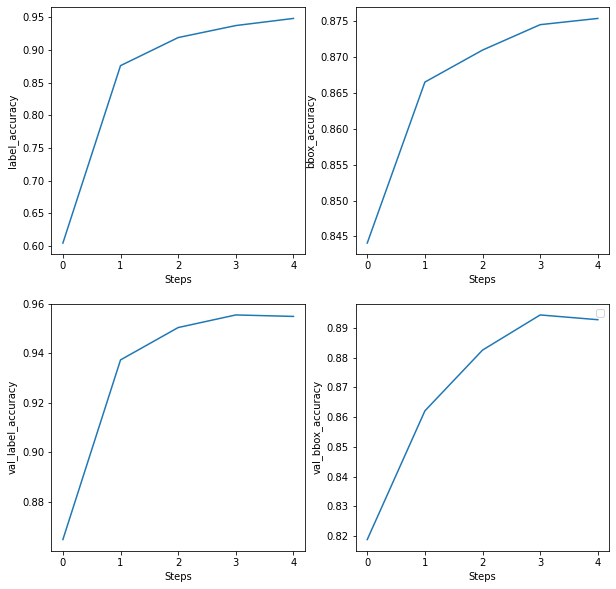

In [9]:
metrics = [i for i in history.history.keys() if i.endswith('bbox_accuracy') or i.endswith('label_accuracy')]
fig , axes = plt.subplots(2,2,figsize=(10,10))

for row in range(2):
  for col in range(2):
    axes[row , col].plot(history.history[metrics[(row*2 + col)]])
    axes[row , col].set_xlabel('Steps')
    axes[row , col].set_ylabel(metrics[(row*2 + col)])

plt.legend()
plt.show()

In [10]:
model.save('mnist_labelled.h5')

1/1 [==============================] - 0s 15ms/step


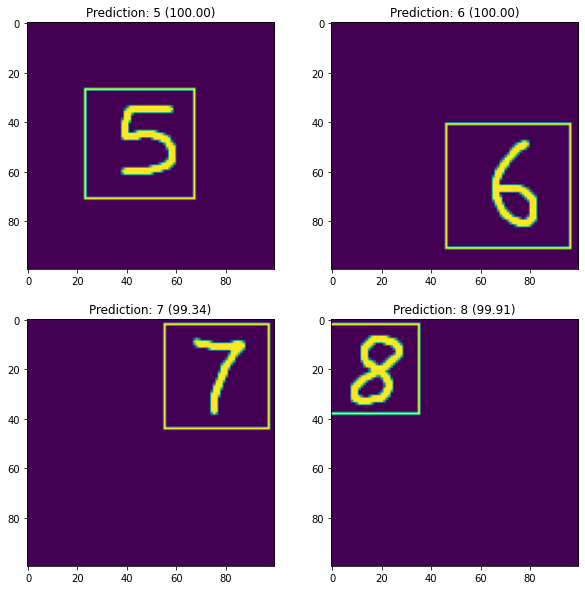

In [11]:
fig , axes = plt.subplots(2,2,figsize=(10,10))

for row in range(2):
  for col in range(2):
    img = cv.imread(f'{(row*2 + col) + 5}.png')
    img = cv.cvtColor(img , cv.COLOR_BGR2GRAY)
    img = np.invert(img)

    X = np.expand_dims(img , axis=-1)
    X = np.asarray([X])
    X = X / 255.0

    val , label = model.predict(X)
    x , y , h , w = (label[0] * 100).astype('uint8').tolist()
    img = cv.rectangle(img ,(x - w//2,y + h//2), (x + h//2,y - w//2) , color=(255,0,0))
    axes[row,col].imshow(img)
    axes[row,col].set_title('Prediction: {} ({:.2f})'.format(np.argmax(val) , np.max(val)*100))
  

plt.show()

In [12]:
def bbox_to_coords(bbox , size):
  x , y , h , w = (bbox * size).astype('uint8').tolist()
  (x1 , y1) = (x - w//2,y + h//2)
  (x2 , y2) = (x + h//2,y - w//2)
  return (x1 , y1) , (x2 , y2)

def IoU(pd_bbox , gt_bbox): # pd_label=predicted label , gt_label= Ground Truth Label
  
  (min_x1 , min_y1) , (max_x1 , max_y1) = bbox_to_coords(pd_bbox , 100)
  (min_x2 , min_y2) , (max_x2 , max_y2) = bbox_to_coords(gt_bbox , 100)
  box1 = box(min_x1 , min_y1 , max_x1 , max_y1)
  box2 = box(min_x2 , min_y2 , max_x2 , max_y2)
  intersection = box1.intersection(box2)
  if intersection.area > 0 and box1.area > 0 and box2.area > 0:
    iou = intersection.area / (box1.area + box2.area - intersection.area)
  else:
    iou = 0
  return iou


In [13]:
total_iou= 0
_ , labels = model.predict(X_test)

for (pd_bbox , gt_bbox) in zip(labels , Y_test[1]):
  total_iou += IoU(pd_bbox , gt_bbox)

print('Average IoU: ' , total_iou/Y_test[1].shape[0])

313/313 [==============================] - 2s 5ms/step
Average IoU:  0.8193197856176048
